# [RNN(Recurrent Neural Networks)](https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D)

## [LSTM(Long Short Term Memory)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   
> Vanilla RNN은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 그래디언트가 점차 줄어 학습능력이 크게 저하되는 것으로 알려져 있습니다. 이를 `vanishing gradient problem`이라고 합니다.    
  
이 문제를 극복하기 위해서 고안된 것이 바로 LSTM입니다.

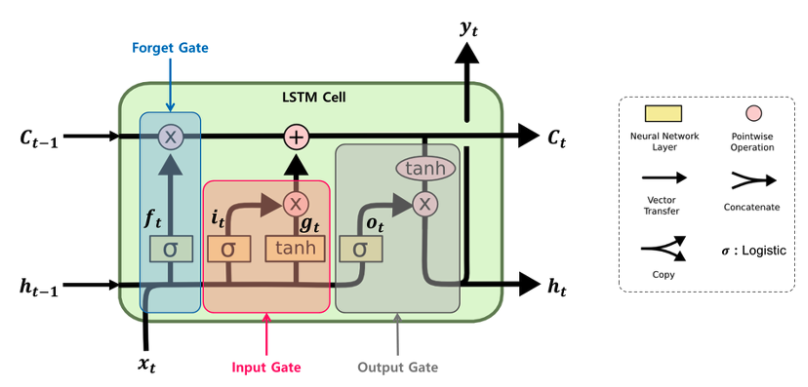

## GRU(Gated Recurrent Unit)
GRU는 LSTM과 비슷한 이유로 만들어졌으며, LSTM보다 구조가 단순하다.  
  
- Update Gate
  > LSTM의 Forget Gate와 Input Gate를 합친 Gate이다. 이전의 정보를 얼마나 통과시킬지 결정하는 Gate이다.  
- Reset Gate
  > 이전 hidden sate의 정보를 얼마나 잊을 지를 결정하는 Gate이다. Sigmoid 활성함수를 통과시켜 0 ~ 1 사이의 범위로 잊을 정보의 양을 결정한다.

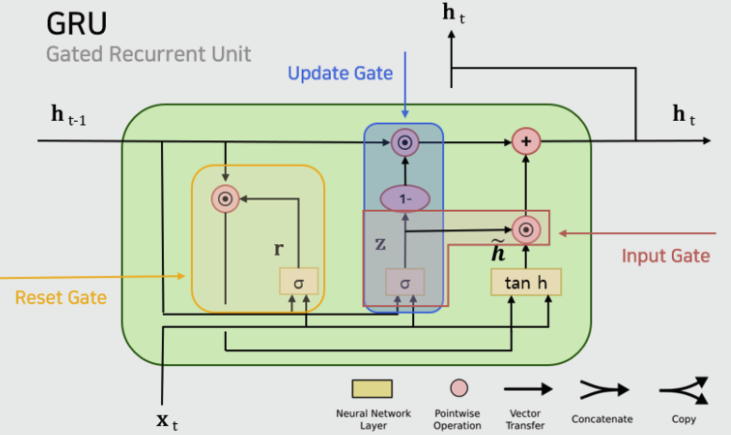

# 예제1

## [Load Data](https://github.com/e9t/nsmc)

In [ ]:
import numpy as np
import pandas as pd

import torch
from torchtext.vocab import build_vocab_from_iterator

from tqdm.auto import tqdm

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


In [ ]:
df_ko = pd.read_csv(DATA_PATH+"naver_review/naver_review_train.csv", sep="\t")

print(f'{df_ko.isnull().sum().sum()} / {df_ko.shape}')
df_ko.head()

5 / (150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
df_ko = df_ko.dropna().reset_index(drop=True)

print(f'{df_ko.isnull().sum().sum()} / {df_ko.shape}')
df_ko.head()

0 / (149995, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Text Preprocessing

### Cleaning

In [ ]:
df_ko['document'] = df_ko['document'].map(lambda x: x.strip())

print(f'{df_ko.isnull().sum().sum()} / {df_ko.shape}')
df_ko.head()

0 / (149995, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### Tokenization

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 9.24 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 52.5 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-04-23 07:31:43--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbuc

In [ ]:
from konlpy.tag import Mecab

mecab = Mecab()

In [ ]:
tokens = mecab.pos(df_ko["document"][0])
len(tokens)

10

In [ ]:
df_ko["document"][0]

'아 더빙.. 진짜 짜증나네요 목소리'

### Stemming / Stopword

In [ ]:
def tokenizer(text):
    tokens = mecab.pos(text)
    return [ token[0] for token in tokens if token[1][0] in "NVJ"]

In [ ]:
tokenizer(df_ko["document"][0])[:5]

['짜증', '나', '네요', '목소리']

In [ ]:
def yield_tokens(data,tokenizer):
    for text in tqdm(data):
        yield tokenizer(text)

### 어휘집 생성
- `<pad>(패딩)`: 0
- `<unk>(정의되지 않은 문자)`: 1

In [ ]:
gen = yield_tokens(df_ko["document"],tokenizer) # 토큰화
vocab = build_vocab_from_iterator(gen,specials=["<pad>","<unk>"]) # 어휘집
vocab.set_default_index(vocab["<unk>"])
len(vocab)

  0%|          | 0/149995 [00:00<?, ?it/s]

41294

In [ ]:
vocab(['짜증', '나', '네요', '목소리', 'karns'])

[143, 20, 199, 517, 1]

In [ ]:
vocab.lookup_tokens([126, 18, 203, 682, 1, 0])

['연출', '봤', '준', '심리', '<unk>', '<pad>']

In [ ]:
features = [ vocab(tokenizer(text)) for text in tqdm(df_ko["document"].tolist())]
len(features)

  0%|          | 0/149995 [00:00<?, ?it/s]

149995

### Padding

In [ ]:
max_len = max(len(lst) for lst in features)
max_len

69

In [ ]:
features = [ lst + [0] * (max_len - len(lst))  if len(lst) < max_len else lst for lst in tqdm(features)]
features = np.array(features)
features.shape

  0%|          | 0/149995 [00:00<?, ?it/s]

(149995, 69)

In [ ]:
max_len == len(features[:1][0])

True

## Dataset

In [ ]:
target = df_ko["label"].to_numpy()
target.shape

(149995,)

In [ ]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self,x,y=None):
        self.x = x # features
        self.y = y.reshape(-1,1) # target

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,idx):
        item = {}
        item["x"] = torch.LongTensor(self.x[idx])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item

In [ ]:
dt = ReviewDataset(features, target)
len(dt)

149995

## DataLoader

In [ ]:
dl = torch.utils.data.DataLoader(dt,batch_size=256,shuffle=False)
len(dl)

586

In [ ]:
batch = next(iter(dl))
batch['x'][:2], batch['y'][:2]

(tensor([[ 143,   20,  199,  517,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0],
         [ 350,  251,  466,    3,   76, 1191,   32,  586,  713,   27,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0]]),
 tensor([[0.],
         [1.]]))

## GRU Model

Parameters
- input_size : 피쳐개수
- hidden_size : 은닉상태의 출력개수
- batch_first : 입력 데이터가 batch 먼저일 경우 True , 입력길이가 먼저일경우 False
  
Output
- output
- hidden_state

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class GRU_net(nn.Module):
  def __init__(self, size_vocab, device, num_output=1, dim_embed=64, hidden_size=64, linear_size=64, num_layers=1):
    super().__init__()
    self.device = device
    self.num_output = num_output
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.embed = nn.Embedding(size_vocab, dim_embed)
    self.gru = nn.GRU(input_size=dim_embed, hidden_size=hidden_size,
                        num_layers=num_layers)
    self.fclayer = nn.Linear(hidden_size, linear_size)
    self.outlayer = nn.Linear(linear_size, num_output)

  def forward(self, x): # (batch, seq_len)
    emb = self.embed(x) # (batch, seq_len, dim_embed)

    # 초기화
    hidden_state = Variable(torch.zeros(self.num_layers, emb.size(0),
                                  self.hidden_size, requires_grad=True)).to(self.device)

    out, hidden_state = self.gru(emb.transpose(1,0), hidden_state)
    h = hidden_state[-1] # 마지막 hidden 값만 사용

    h = self.fclayer(h).relu()
    predict = self.outlayer(h)
    return predict

In [ ]:
model = GRU_net(len(vocab), device).to(device)
model

GRU_net(
  (embed): Embedding(41294, 64)
  (gru): GRU(64, 64)
  (fclayer): Linear(in_features=64, out_features=64, bias=True)
  (outlayer): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
batch["x"].to(device).shape

torch.Size([256, 69])

In [ ]:
model(batch["x"].to(device)).shape

torch.Size([256, 1])

## Engine

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()
    for batch in dataloader:
        pred = model(batch["x"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [ ]:
from sklearn.metrics import accuracy_score

@torch.inference_mode()
def test_loop(dataloader,model,loss_fn,device):
    epoch_loss = 0
    total_acc = 0
    model.eval()

    pred_list = []
    sig = torch.nn.Sigmoid()

    for batch in dataloader:

        pred = model(batch["x"].to(device))

        pred_ = sig(pred)
        pred_ = pred_.to("cpu").numpy()
        pred_list.append(pred_)

        if batch.get("y") is not None:
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()

            pred_ = (pred_ > 0.5).astype(int)
            total_acc += accuracy_score(batch["y"].to("cpu").numpy(), pred_)

    epoch_loss /= len(dataloader)
    total_acc /= len(dataloader)

    # epoch_pred = np.concatenate(pred_list)
    return epoch_loss , total_acc

## random_split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(features, target, test_size=0.1, shuffle=True)

In [ ]:
len(X_tr), len(y_tr), len(X_te), len(y_te)

(134995, 134995, 15000, 15000)

In [ ]:
X_tr[0], y_tr[0]

(array([   3,   19, 4907,    5,   73,    9,  106, 1976,   83,   31,    2,
         751,  158,  161,  161,  161,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]),
 0)

## KFold

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

SEED = 42
n_splits = 5
cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

## Train

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
best_score_list = []
epochs = 100
batch_size = 256 #128
vocab_size = len(vocab)

loss_fn = torch.nn.BCEWithLogitsLoss()

for i,(tri,vai) in enumerate(cv.split(X_tr)):
    model = GRU_net(vocab_size, device).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    train_dt = ReviewDataset(X_tr[tri],y_tr[tri])
    valid_dt = ReviewDataset(X_tr[vai],y_tr[vai])
    train_dl = DataLoader(train_dt, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_dt, batch_size=batch_size,shuffle=False)

    best_score = 0
    patience = 0

    for epoch in tqdm(range(epochs)):

        train_loss = train_loop(train_dl, model, loss_fn, optimizer, device )
        valid_loss , score = test_loop(valid_dl, model, loss_fn, device  )

        patience += 1
        if best_score < score:
            print(f'best score: {train_loss, valid_loss, score}') # 트레인 로스, 벨리드 로스, 스코어
            patience = 0
            best_score = score
            # torch.save(model.state_dict(),f"model_{i}.pth")

        if patience == 20:
            break

    print(f"Fold ({i}), BEST ACC: {best_score}")
    best_score_list.append(best_score)

  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.596647185525058, 0.46204374871164, 0.7774958007967337)
best score: (0.428697282033509, 0.4215809632584734, 0.7993062643689551)
best score: (0.3798621447306674, 0.4024551395537718, 0.8113511029411765)
best score: (0.34360714111989143, 0.40092632343184276, 0.8150161155263992)
best score: (0.3129643992790114, 0.4004039019346237, 0.8187895146266053)
Fold (0), BEST ACC: 0.8187895146266053


  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.5567926747539033, 0.4537000703924107, 0.7793897777271286)
best score: (0.416123369152512, 0.42070629742910276, 0.7993375416204218)
best score: (0.3713651649053628, 0.41086100210558696, 0.8089244837085777)
best score: (0.3384578013660218, 0.41287431345795683, 0.8102399863247185)
best score: (0.3070887241035841, 0.409867580206889, 0.8115297858530204)
Fold (1), BEST ACC: 0.8115297858530204


  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.5855943145345173, 0.46693394600220445, 0.774051896702077)
best score: (0.42863198839375194, 0.429962065703464, 0.7961995971737751)
best score: (0.38015746801950356, 0.4162669131216013, 0.8071611899476772)
best score: (0.3454560092275177, 0.4196138775573586, 0.8087938005390836)
best score: (0.3140330370427308, 0.4177133269467444, 0.8126207735452671)
Fold (2), BEST ACC: 0.8126207735452671


  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.6088859583670494, 0.4771790844651888, 0.7688849566949421)
best score: (0.43357917355700126, 0.44163950265578505, 0.7902017971103535)
best score: (0.38081626608190944, 0.41426182074366874, 0.8065749737394958)
best score: (0.3444392641926829, 0.41145401180915114, 0.8107079063936895)
best score: (0.3133722508052514, 0.42124891056204744, 0.8140781076581577)
Fold (3), BEST ACC: 0.8140781076581577


  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.5720695264249052, 0.4598089293488916, 0.7781402360472491)
best score: (0.42310488887872744, 0.4204217977118942, 0.8038479690225147)
best score: (0.3758120413216369, 0.40873121146885855, 0.8120401315007134)
best score: (0.34068170034489925, 0.4131044543014382, 0.8131311191929602)
best score: (0.30936136576942924, 0.4108706901095948, 0.8173578836015538)
Fold (4), BEST ACC: 0.8173578836015538


## Test

In [ ]:
test_dt = ReviewDataset(X_te,y_te)
test_dl = DataLoader(test_dt, batch_size=batch_size,shuffle=False)

loss , pred = test_loop(test_dl, model, loss_fn, device  )

loss, pred

(0.9674790228827524, 0.7967042540142729)

# [예제2 with text generator](https://wikidocs.net/45101)

## [텍스트 생성(text generator)](https://www.analyticsvidhya.com/blog/2018/03/text-generation-using-python-nlp/)
- 텍스트 생성은 인공지능이 기존의 텍스트로부터 새로운 텍스트를 생성하는 프로세스입니다.
- 뉴스 기사, 시, 코드, 스크립트, 음악, 이메일 등과 같이 텍스트 생성을 다루는 자연어 처리(NLP)의 하위 분야라고 부면 될 것 같습니다.

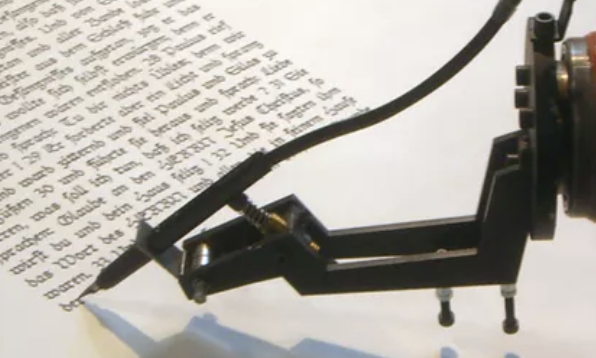

### 텍스트 생성의 활용분야
- 챗봇
  - 챗봇은 인간 사용자와의 대화를 시뮬레이션하도록 설계된 컴퓨터 프로그램입니다.
  - 텍스트 생성은 보다 자연스럽고 대화에 몰입할 수 있는 챗봇을 만드는데 사용할 수 있습니다.
- 언어 번역
  - 언어 번역은 텍스트를 한 언어에서 다른 언어로 변환하는 프로세스입니다.
  - 텍스트 생성은 보다 정확하고 효율적인 언어 번역 모델을 만드는데 사용할 수 있습니다.

## Load Data

In [ ]:
from tqdm.auto import tqdm
import random
import os

import pandas as pd
import numpy as np
from string import punctuation

import torch

In [ ]:
SEED = 42

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/text_generators/"

Mounted at /content/drive


In [ ]:
df = pd.read_csv(f'{DATA_PATH}ArticlesApril2018.csv')

print(df.shape)
df.head()

(1324, 15)


,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


## Text Preprocessing

### Cleaning

In [ ]:
df['headline'] = df['headline'].map(lambda x: x.strip()) # 문자열의 앞뒤 공백 제거
df = df[df['headline'] != 'Unknown'] # Unknown 제거
df['headline'] = df['headline'].map(lambda x: x.encode('utf8').decode('ascii','ignore')) # 아스키 코드로 변환
df['headline'] = df['headline'].map(lambda x: x.lower()) # 단어 소문자변환

print(f'{df.isnull().sum().sum()} / {df.shape}')
df.head()

0 / (1214, 15)


,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,former n.f.l. cheerleaders settlement offer: $...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,e.p.a. to unveil a new rule. its effect: less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"the new noma, explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
8,5adf2108068401528a2aa5b3,730,By JOHN SCHWARTZ,article,how a bag of texas dirt became a times tradition,"['Texas', 'Soil', 'Pregnancy and Childbirth', ...",68,Insider,2,2018-04-24 12:20:21,Unknown,What can you do when you want your child to be...,The New York Times,News,https://www.nytimes.com/2018/04/24/insider/how...
9,5adedaa8068401528a2aa4e6,482,By NATALIE PROULX,article,is school a place for self-expression?,[],66,Learning,0,2018-04-24 11:21:04,Unknown,Are you encouraged to question and articulate ...,The New York Times,News,https://www.nytimes.com/2018/04/24/learning/is...


### 토큰화 & 어휘집

In [ ]:
import spacy # 형태소 분석기

In [ ]:
!python -m spacy download en_core_web_sm

2023-09-07 06:00:39.319087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
nlp = spacy.load("en_core_web_sm") # 형태소 분석기 객체 생성

In [ ]:
def tokenizer(text):
    doc = nlp(text)
    return [ token.lemma_ for token in doc if token.tag_[0] in "NVJ"] # N(명사), V(동사), J(형용사)


In [ ]:
def yield_tokens(data, tokenizer):
    for text in tqdm(data):
        yield tokenizer(text)

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

gen = yield_tokens(df['headline'],tokenizer)
vocab = build_vocab_from_iterator(gen, specials=["<pad>","<unk>"])
vocab.set_default_index(vocab["<unk>"])
len(vocab)

  0%|          | 0/1214 [00:00<?, ?it/s]

2744

In [ ]:
vocab.lookup_tokens([5])[0]

'do'

In [ ]:
preprocessed_headline = [ text for text in df['headline'].tolist()]
len(preprocessed_headline)

1214

In [ ]:
sequences = list()

for sentence in preprocessed_headline:

    # 각 샘플에 대한 정수 인코딩
    encoded = vocab(tokenizer(sentence))
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[81, 308],
 [81, 308, 260],
 [81, 308, 260, 2389],
 [81, 308, 260, 2389, 312],
 [81, 308, 260, 2389, 312, 768],
 [81, 308, 260, 2389, 312, 768, 1621],
 [78, 2650],
 [78, 2650, 6],
 [78, 2650, 6, 87],
 [78, 2650, 6, 87, 1463],
 [78, 2650, 6, 87, 1463, 300]]

### 패딩

In [ ]:
max_len = max(len(lst) for lst in sequences)
max_len

15

In [ ]:
sequences = [ [0] * (max_len - len(lst)) + lst  if len(lst) < max_len else lst for lst in sequences]
sequences = np.array(sequences)
sequences.shape

(4842, 15)

In [ ]:
sequences[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   81,  308],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   81,  308,  260],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          81,  308,  260, 2389]])

In [ ]:
X = sequences[:,:-1]
y = sequences[:,-1]

X.shape, y.shape

((4842, 14), (4842,))

## Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class GeneratorDataset(Dataset):
    def __init__(self,sequences):
        self.x = sequences[:,:-1]
        self.y = sequences[:,-1]

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        return {
            'x': torch.tensor(self.x[idx]),
            'y': torch.tensor(self.y[idx])
        }

In [ ]:
dt = GeneratorDataset(sequences)
len(dt)

4842

In [ ]:
dt[0]

{'x': tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 81]),
 'y': tensor(308)}

## DataLoader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
dl = DataLoader(dt,batch_size = 128)
batch = next(iter(dl))
batch

{'x': tensor([[   0,    0,    0,  ...,    0,    0,   81],
         [   0,    0,    0,  ...,    0,   81,  308],
         [   0,    0,    0,  ...,   81,  308,  260],
         ...,
         [   0,    0,    0,  ..., 2161, 2718,  432],
         [   0,    0,    0,  ...,    0,    0,    3],
         [   0,    0,    0,  ...,    0,    3,  200]]),
 'y': tensor([ 308,  260, 2389,  312,  768, 1621, 2650,    6,   87, 1463,  300,  493,
         2144, 2019, 1504,  236,  399,   49,   91,  527,   48,  105,  497,  655,
         2272,   93,   46,  125, 1864,  125,  656,  242,  926, 1308,  410,  178,
           15,  640,  843, 2664,  724,  228,  173,   15,  102,  316, 1572,  365,
           50,   14,  517,  596,  201,   65,   83,  138,    2,  731,  491, 2246,
           55,  182,   32, 2379,  840, 1401,  345, 1135, 1452, 1264,  280, 2143,
         1146,  526, 2736, 2366,  212, 1984,  676, 1417,  517,   73,  387,   47,
          281,    2,   27, 1108,  371,   18,   82,  108,   85,    4,    3,  176,
        

## Model

In [ ]:
import torch.nn as nn

In [ ]:
class GRU_net(nn.Module):
  def __init__(self, size_vocab, device, dim_embed=128, hidden_size=256, linear_size=128, num_layers=1):
    super().__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.embed = nn.Embedding(size_vocab, dim_embed)
    self.gru = nn.GRU(input_size=dim_embed, hidden_size=hidden_size,
                        num_layers=num_layers)
    self.fclayer = nn.Linear(hidden_size, linear_size)
    self.outlayer = nn.Linear(linear_size, size_vocab)

  def forward(self, x): # (batch, seq_len)
    emb = self.embed(x) # (batch, seq_len, dim_embed)

    # 초기화
    hidden_state = torch.zeros(self.num_layers, emb.size(0),
                                  self.hidden_size, requires_grad=True).to(self.device)

    out, hidden_state = self.gru(emb.transpose(1,0), hidden_state)
    h = hidden_state[-1] # 마지막 hidden 값만 사용

    h = self.fclayer(h).relu()
    predict = self.outlayer(h)
    return predict

In [ ]:
model = GRU_net(len(vocab), device).to(device)
model

GRU_net(
  (embed): Embedding(2744, 128)
  (gru): GRU(128, 256)
  (fclayer): Linear(in_features=256, out_features=128, bias=True)
  (outlayer): Linear(in_features=128, out_features=2744, bias=True)
)

In [ ]:
pred = model(batch['x'].to(device))
pred.shape

torch.Size([128, 2744])

In [ ]:
batch['y'].shape

torch.Size([128])

## Engine

In [ ]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_loss = np.inf
        self.save_path = save_path

    def is_continuable(self, model, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.trial_counter = 0 # 초기화
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1 # 기존 시도횟수 + 1
            return True
        else:
            return False

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()
    for batch in dataloader:
        pred = model(batch["x"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

## Training

In [ ]:
vocab_size = len(vocab)
batch_size = 128
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 500

In [ ]:
reset_seeds(SEED)
model = GRU_net(len(vocab), device).to(device)
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(num_trials=10, save_path=f'best_model.pt')

train_dt = GeneratorDataset(sequences)
train_dl = DataLoader(train_dt, shuffle=True,batch_size=batch_size)

train_loss_list = []
for i in tqdm(range(epochs)):
    train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
    # print(train_loss)
    train_loss_list.append(train_loss)
    if not early_stopper.is_continuable(model, train_loss):
        print(f'epoch:{i} >> best loss: {early_stopper.best_loss}')
        break

  0%|          | 0/500 [00:00<?, ?it/s]

epoch:209 >> best loss: 0.19729423836657875


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

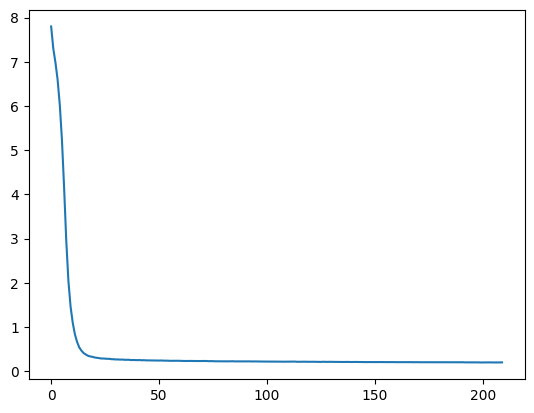

In [ ]:
sns.lineplot(train_loss_list)

## generator

### 샘플링 전략
- 탐욕적 샘플링(greedy sampling)
    - 자연어를 생성할 때, 다음 글자를 선택하는 방법으로 가장 높은 확률을 가진 글자를 선택하는 방법

- 확률적 샘플링(stochastic sampling)
    - 글자의 확률 분포에서 샘플링하는 과정에서 무작위성을 주입하는 방법

### greedy_samling

In [ ]:
@torch.no_grad()
def text_generation_by_greedy_samling(model, vocab, current_word, sentence_size):

    sentence = ''
    sentence += current_word
    init_encoded = vocab([current_word])

    model.eval()
    # n번 반복
    for _ in range(sentence_size):
        encoded = init_encoded
        encoded = [0] * (15 - len(encoded)) + encoded
        encoded = np.array(encoded)
        encoded = torch.tensor(encoded).view(1,-1).to(device)

        pred = model(encoded)
        char_no = pred.argmax(1).item()
        init_encoded.append(char_no)
        word = vocab.lookup_tokens([char_no])[0]

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    return sentence

In [ ]:
text_generation_by_greedy_samling(model, vocab, 'i', 5)

'i amnt voter tax cut be'

In [ ]:
text_generation_by_greedy_samling(model, vocab, 'you', 8)

'you ex - f.b.i deputy chief be send possible'

### stochastic_sampling

In [ ]:
def stochastic_sampling(pred,temp):
    pred = pred / temp
    m = np.max(pred)
    ez = np.exp(pred - m)
    proba_arr = ez / np.sum(ez)
    return np.random.choice(np.arange(pred.shape[0]),p=proba_arr)

In [ ]:
@torch.no_grad()
def text_generation_by_stochastic_sampling(model, vocab, current_word, sentence_size, temp=None):

    sentence = ''
    sentence += current_word
    init_encoded = vocab([current_word])

    model.eval()
    # n번 반복
    for _ in range(sentence_size):
        encoded = init_encoded
        encoded = [0] * (15 - len(encoded)) + encoded
        encoded = np.array(encoded)
        encoded = torch.tensor(encoded).view(1,-1).to(device)

        pred = model(encoded)
        char_no = pred.argmax(1).item()
        if temp is not None:
            pred = pred.view(-1).to("cpu").numpy()
            char_no = stochastic_sampling(pred,temp)

        init_encoded.append(char_no)
        word = vocab.lookup_tokens([char_no])[0]

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    return sentence

In [ ]:
temp_list = [None, 0.1 , 0.5, 1, 2.2]

for temp in temp_list:
    print("온도:",temp)
    sentence = text_generation_by_stochastic_sampling(model, vocab, 'you', 8, temp)
    print(f'sentence >> {sentence}')
    print(end="\n\n")

온도: None
sentence >> you ex - f.b.i deputy chief be send possible


온도: 0.1
sentence >> you ex - f.b.i deputy chief be send possible


온도: 0.5
sentence >> you ex - f.b.i deputy chief be send possible


온도: 1
sentence >> you ex - f.b.i deputy chief be send possible


온도: 2.2
sentence >> you case ex - f.b.i deputy chief be send


